# Notebook 2: (Demo) Dose-Rate Calculations with Visualization
Inputs:
- Simulated MC dose kernel
- Aligned iQID activity image stack
- iQID FoV measurement data
- Optional: parameter file for small-value errors introduced by alignment
(comment out pertinent sections if not desired)

Output:
- Central-slice dose-rate image

In [1]:
# Move the working directory up one level to the one shown to find the source packages.
# Feel free to modify your own system path to accomodate this package if desired.
# Please note this change for all relative paths contained in the notebook.

In [2]:
cd ..

C:\Users\Robin\Documents\Cal\iQID\git_iqid_alphas


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
import matplotlib.ticker as tck

from scipy.ndimage import convolve
from skimage import io
from importlib import reload

from iqid import dpk
reload(dpk)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [4]:
# Parameter files
param_dir = 'parameters'
act_corr = 'activity_correction.csv'
kernel_fname = 'at211_10E6_151_1um_water.txt'
scale_fname = 'scale_data.csv'

# Load and inspect the dose kernel

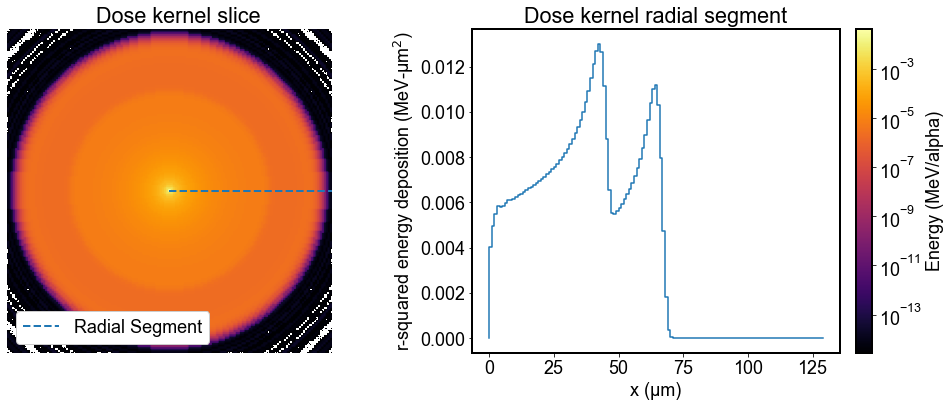

In [5]:
# Load in the Geant4 kernel and average radially. Two modes available:
filename = os.path.join(param_dir, kernel_fname)
dose_kernel = dpk.load_kernel(filename, dim=151, num_alpha_decays=10e6)
radial_kernel = dpk.radial_avg_kernel(dose_kernel, mode='whole')
radial_seg = dpk.radial_avg_kernel(dose_kernel, mode='segment')

# Visualize the kernel, 3D (slice) or r-squared-independent analysis.
xspace = np.arange(len(radial_seg))
mgyxsq = xspace**2 * radial_seg

f, ax = plt.subplots(1,2, figsize=(14,6))

im = ax[0].imshow(radial_kernel[len(radial_kernel)//2,:,:],
                  norm=LogNorm(vmin=min(radial_kernel[np.nonzero(radial_kernel)]),
                               vmax=np.max(radial_kernel)),cmap='inferno')
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Energy (MeV/alpha)')
ax[0].axis('off')
ax[0].set_title('Dose kernel slice')
ax[0].plot([len(radial_kernel)//2, len(radial_kernel)],
           [len(radial_kernel)//2, len(radial_kernel)//2], 
           ls='--', lw=2, label='Radial Segment')
ax[0].legend(facecolor='white', framealpha=1, loc='lower left')

ax[1].step(xspace, mgyxsq)
ax[1].set_xlabel('x (µm)')
ax[1].set_ylabel('r-squared energy deposition (MeV-µm$^2$)')
ax[1].set_title('Dose kernel radial segment')

plt.tight_layout()
plt.show()

<ipython-input-6-10173b13be6a>:15: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(xspace, 1/xspace**2, label='$1/r^2$')


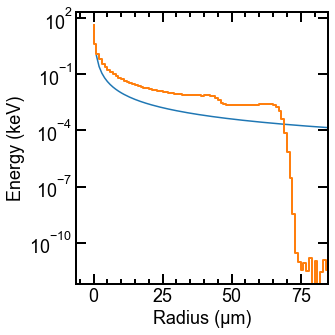

In [6]:
# Show r-squared dependence to explain previous plot

f, ax = plt.subplots(1,1, figsize=(5,5))
ax.minorticks_on()

locmin = tck.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8), numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(tck.NullFormatter())

ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=5, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=5, width=2, direction='in', right='on')

ax.plot(xspace, 1/xspace**2, label='$1/r^2$')
ax.step(xspace, radial_seg*1e3, linewidth=2, label='Dose Kernel Radial Segment')
ax.set_yscale('log')
ax.set_xlabel('Radius (µm)')
ax.set_ylabel('Energy (keV)')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin, 85)
plt.tight_layout()
plt.show()

# Use the FoV data to bin the kernel for the study

The dose kernel is 151 x 151 x 151 with 1 um voxel size. Each data set has a field-of-view measurement, yielding voxels with some (xy) resolution and some (z) resolution corresponding to the slice thickness. We need to crop/pad and rebin the dose kernel to match it. Note that we reshape the kernel to be (z, x, y) to match the image stack dimensions.

Since ~31 um (the XY resolution of this study) is a pretty large voxel size (subsequent studies tend to have better resolution, ~20um/px), we'd like to pad the dose kernel up to a 5x5 kernel in XY (from N=151 to N = 31x5 = 155). This should not change our results or calculations since the dose kernel is zero beyond about 70 um anyway. We are rounding the study um/px from 30.9 to 31, which introduces a small error in the convolution kernel (0.2 um from center to edge). This error is only 0.6% of the voxel size and not discernable in the spatial resolution of the kernel.

In Z, we would like to pad to a multiple of 12 um (the slice thickness), i.e. up to 156.

In [7]:
# Import the field-of-view data and select our sample study from the list.
# Subpx is the factor used to subpixelate (interpolate) the listmode data.
study_idx = 2 # 
px, mm, subpx = np.genfromtxt(os.path.join(param_dir, scale_fname),
                              delimiter=',', skip_header=1, usecols=(1,2,3), unpack=True)

# Pad the kernel up to integer multiples of the voxel size.
um_per_px = mm/px * 1e3 / subpx
study_um_px = np.round(um_per_px[study_idx])
study_slice_z = 12 # all slices were 12 um

print('Study um/px: {:.2f}'.format(study_um_px))

padded_kernel = dpk.pad_kernel_to_vsize(radial_kernel, 
                                            vox_xy=study_um_px, 
                                            slice_z=study_slice_z)

print('Padded kernel dimensions: {}'.format(padded_kernel.shape))

# Bin the kernel down to match the iQID image resolution.
d, m, n = padded_kernel.shape
binned_kernel = dpk.bin_ndarray(padded_kernel, 
                                    (int(d/study_slice_z), 
                                     int(m/study_um_px), 
                                     int(n/study_um_px)))

print('Binned kernel dimensions: {}'.format(binned_kernel.shape))

Study um/px: 31.00
Padded kernel dimensions: (156, 155, 155)
Binned kernel dimensions: (13, 5, 5)


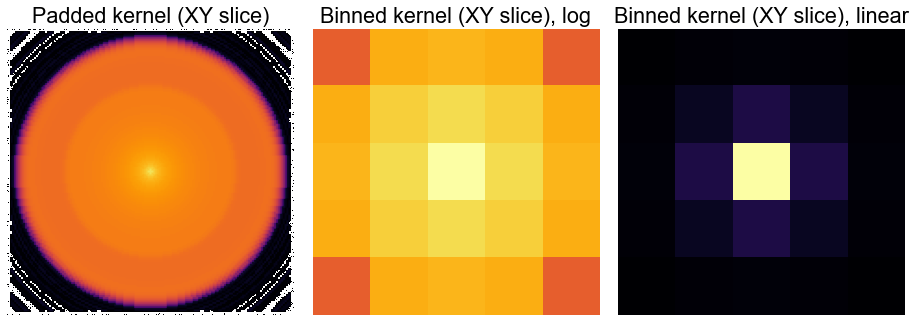

In [8]:
# Visualize the kernel processing.
f, ax = plt.subplots(1,3, figsize=(13,5))
ax[0].imshow(padded_kernel[len(padded_kernel)//2,:,:],
             norm=LogNorm(vmin=min(padded_kernel[np.nonzero(padded_kernel)]),
                          vmax=np.max(padded_kernel)),cmap='inferno')
ax[0].axis('off')
ax[0].set_title('Padded kernel (XY slice)')

ax[1].imshow(binned_kernel[len(binned_kernel)//2,:,:],
             norm=LogNorm(vmin=min(binned_kernel[np.nonzero(binned_kernel)]),
                          vmax=np.max(binned_kernel)),cmap='inferno')
ax[1].axis('off')
ax[1].set_title('Binned kernel (XY slice), log')

ax[2].imshow(binned_kernel[len(binned_kernel)//2,:,:], cmap='inferno')
ax[2].axis('off')
ax[2].set_title('Binned kernel (XY slice), linear')

plt.tight_layout()
plt.show()

In [9]:
# Demonstrate that total energy deposition is preserved.
print(np.isclose(np.sum(radial_kernel), np.sum(binned_kernel)))

True


# Obtain dose rate image (Time Point 1)
Via convolution of the activity snapshot image (events in a second) with the dose kernel.
Both studies have the same FoV measurement, so we don't need to re-bin the dose kernel between them.

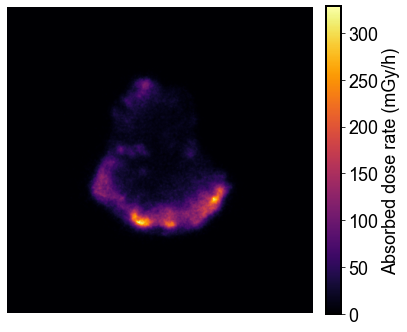

In [10]:
# Load the activity stack.
imdir = os.path.join('data', 'H700', '25March')
astack_mBq = io.imread(os.path.join(imdir, 'aligned', 'imstack.tif'))

# Account for small-value errors introduced by rotations.
a_diff = np.genfromtxt(os.path.join(param_dir, act_corr),
                            delimiter=',', skip_header=1,
                            usecols=(2))
a_corr = a_diff/100
astack_corr = astack_mBq / (1+a_corr[2]) # this study has index 2 in the list of all data sets

# Get the number of events in one second and correct for detector efficiency.
eff_4pi = 4.25/4.32
eff_2pi = 0.5*eff_4pi
efficiency_factor = 1/eff_2pi
time_snapshot = 1  # second
events = astack_corr * efficiency_factor * time_snapshot * 1e-3 # convert mBq > Bq

# Unit conversions and convolution.
vox_vol_m = (study_um_px * 1e-6)**2 * (study_slice_z * 1e-6)
mgy_kernel = dpk.mev_to_mgy(binned_kernel, vox_vol_m)
mgy_per_hr = convolve(events, mgy_kernel) * 60 * 60

# Extract the central slice dose rate image.
central_slice = mgy_per_hr[len(mgy_per_hr)//2,:,:]

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(central_slice, cmap='inferno')
ax.axis('off')
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Absorbed dose rate (mGy/h)')
plt.tight_layout()
plt.show()

# Obtain dose rate image (Time Point 2)

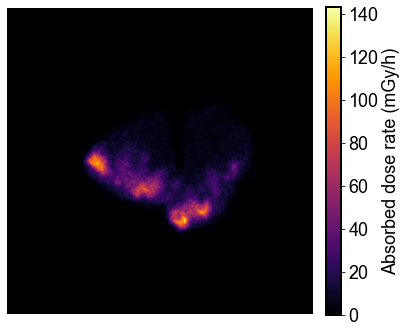

In [11]:
# Load the activity stack from an example directory.
imdir = os.path.join('data', 'H700', '26March')
astack_mBq = io.imread(os.path.join(imdir, 'aligned', 'imstack.tif'))
astack_corr = astack_mBq / (1+a_corr[3])

# Get the number of events in one second and correct for detector efficiency.
# Other parameters remain the same.
events = astack_mBq * efficiency_factor * time_snapshot * 1e-3 # convert mBq > Bq

# Unit conversions and convolution.
vox_vol_m = (study_um_px * 1e-6)**2 * (study_slice_z * 1e-6)
mgy_kernel = dpk.mev_to_mgy(binned_kernel, vox_vol_m)
mgy_per_hr = convolve(events, mgy_kernel) * 60 * 60

# Visualize the dose rate image of the central slice.
central_slice = mgy_per_hr[len(mgy_per_hr)//2,:,:]

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(central_slice, cmap='inferno')
ax.axis('off')
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Absorbed dose rate (mGy/h)')
plt.tight_layout()
plt.show()